In [19]:
import wandb

api = wandb.Api()
runs = api.runs("ckodserteam/greedyNeuron6")
forgetting_runs = {"greedy": [], "normal": []}
l=[]
for run in runs:
    if run.name.startswith("25final") and run.config['seed'] != 0 and run.config['task'] == "MNIST-Split HARD":
        forgetting_runs[run.config['mode']].append(run)
        if run.config['mode']=="normal":
            l.append((run.config['seed'], run.name))
print(len(l))
for k in forgetting_runs:
    print(len(forgetting_runs[k]))
print(sorted(l))

100
100
100
[(1, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (2, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (3, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (4, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (5, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (6, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (7, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (8, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (9, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (10, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (11, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (12, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (13, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (14, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (15, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (16, '25final_MNIST_MODEnormal_MODEL_MLP_BS512_LR0.002_E25'), (17,

In [20]:
from tqdm import tqdm

accuracies={k:{f'task_{j}':[[] for i in range(126)] for j in range(5)} for k in ['greedy', 'normal']}
for mode in forgetting_runs:
    for j,run in enumerate(tqdm(forgetting_runs[mode])):
        for task_id in range(5):
            for i, row in run.history(keys=[f"performance_eval/test_accuracy_{task_id}"]).iterrows():
                accuracies[mode][f"task_{task_id}"][i].append(row[f'performance_eval/test_accuracy_{task_id}'])

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [21]:
import numpy as np

smean={mode:{f'task_{j}':[np.mean(accuracies[mode][f"task_{j}"][i]) for i in range(126)] for j in range(5)} for mode in ['greedy', 'normal']}
sstd={mode:{f'task_{j}':[np.std(accuracies[mode][f"task_{j}"][i]) for i in range(126)] for j in range(5)} for mode in ['greedy', 'normal']}

In [22]:
for k in forgetting_runs:
    print(len(forgetting_runs[k]))

100
100


greedy winter (0.0, 0.0, 1.0, 1.0)
normal autumn (1.0, 0.0, 0.0, 1.0)


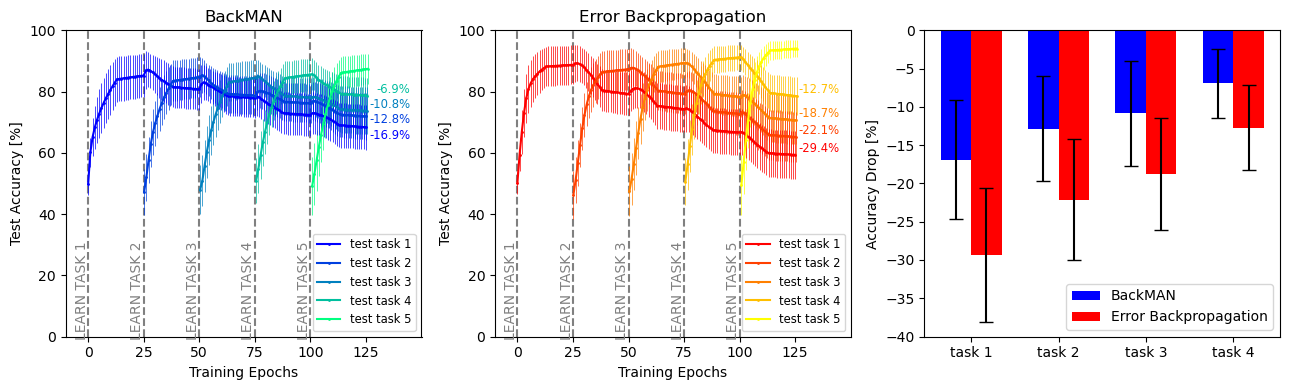

In [31]:
import numpy as np
import matplotlib.pyplot as plt

cmap_name={"greedy": "winter", "normal":"autumn"}
name_translation={"greedy": "BackMAN", "normal": "Error Backpropagation"}

fig = plt.figure(figsize=(13, 4))
ax=[]
ax.append(fig.add_subplot(1, 3, 1))
ax.append(fig.add_subplot(1, 3, 2, sharey = ax[0]))
ax.append(fig.add_subplot(1, 3, 3))


for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)
    last=100000
    for task_id in range(4,-1,-1):
        # Sample data
        ax[ax_id].axvline(x=25*task_id, color='gray', linestyle='--')
        # Add text labels
        ax[ax_id].text(25*task_id-6, 0.05, f'LEARN TASK {task_id+1}', color='gray', rotation='vertical', fontsize=10)

        x = np.arange(25*task_id, 126)+1/5*task_id
        y = np.array(smean[mode][f'task_{task_id}'][25*task_id:])*100
        std_dev = np.array(sstd[mode][f'task_{task_id}'][25*task_id:])*100

        if task_id!=4:
            ax[ax_id].text(125+20, min(last-5, y[-1]), f'{y[-1]-y[25]:.1f}%', ha='right', va='bottom', color=cmap(task_id), fontsize="small")
        last=min(last-5, y[-1])
        # Plotting the error lines
        ax[ax_id].errorbar(x, y, yerr=std_dev/2, linestyle='', color=cmap(task_id), elinewidth=0.5)

        # Customizing the plot
        ax[ax_id].set_xlabel('Training Epochs')
        ax[ax_id].set_ylabel('Test Accuracy [%]')
        ax[ax_id].set_title(name_translation[mode])
        custom_ticks = [25*i for i in range(6)]
        ax[ax_id].set_xticks(custom_ticks)
        ax[ax_id].set_ylim(bottom=0, top=100)
        ax[ax_id].set_xlim(-10,150)

for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)
    for task_id in range(5):
        x = np.arange(25*task_id, 126)+1/5*task_id
        y = np.array(smean[mode][f'task_{task_id}'][25*task_id:])*100
        ax[ax_id].plot(x, y, marker='o', linestyle='-', color=cmap(task_id), label=f'test task {task_id+1}', markersize=1)
        ax[ax_id].legend(fontsize='small')

# Example data


labels = [f'task {task_id+1}' for task_id in range(4)]
means = {mode: np.array([np.mean([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                         +accuracies[mode][f"task_{task_id}"][125][j]
                         for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}
std_devs = {mode: np.array([np.std([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                           +accuracies[mode][f"task_{task_id}"][125][j]
                           for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}

# Create a bar plot with paired bars
x = np.arange(len(labels))
width = 0.35
ax_id=2
for sign, mode in zip([-1,+1],['greedy', 'normal']):
    cmap=plt.cm.get_cmap(cmap_name[mode], 2)
    print(mode, cmap_name[mode], cmap(0))
    ax[ax_id].bar(x + sign*width/2, means[mode]*100, width, align='center', yerr=np.array(std_devs[mode]*100)/2, capsize=5, label=name_translation[mode], color=[cmap(0) for i in range(4)])

# Customize the plot
ax[ax_id].set_xticks(x)
ax[ax_id].set_xticklabels(labels)
ax[ax_id].set_ylabel('Accuracy Drop [%]')
# ax.set_title('Accuracy drop compared to')
ax[ax_id].legend(loc='lower right')

plt.tight_layout()
# Display the plot
plt.savefig('forgetting_combined_high.png', dpi=1000)
plt.show()

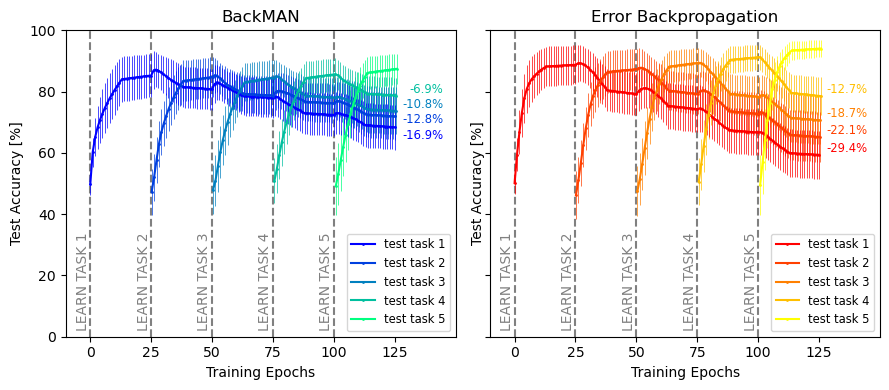

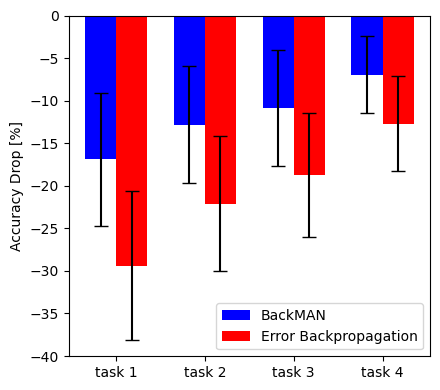

In [44]:
import numpy as np
import matplotlib.pyplot as plt

cmap_name={"greedy": "winter", "normal":"autumn"}
name_translation={"greedy": "BackMAN", "normal": "Error Backpropagation"}

fig, ax = plt.subplots(1, 2,figsize=(9, 4), sharey="row")


for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)
    last=100000
    for task_id in range(4,-1,-1):
        # Sample data
        ax[ax_id].axvline(x=25*task_id, color='gray', linestyle='--')
        # Add text labels
        ax[ax_id].text(25*task_id-6, 3, f'LEARN TASK {task_id+1}', color='gray', rotation='vertical', fontsize=10)

        x = np.arange(25*task_id, 126)+1/5*task_id
        y = np.array(smean[mode][f'task_{task_id}'][25*task_id:])*100
        std_dev = np.array(sstd[mode][f'task_{task_id}'][25*task_id:])*100

        if task_id!=4:
            ax[ax_id].text(125+20, min(last-5, y[-1]), f'{y[-1]-y[25]:.1f}%', ha='right', va='bottom', color=cmap(task_id), fontsize="small")
        last=min(last-5, y[-1])
        # Plotting the error lines
        ax[ax_id].errorbar(x, y, yerr=std_dev/2, linestyle='', color=cmap(task_id), elinewidth=0.5)

        # Customizing the plot
        ax[ax_id].set_xlabel('Training Epochs')
        ax[ax_id].set_ylabel('Test Accuracy [%]')
        ax[ax_id].set_title(name_translation[mode])
        custom_ticks = [25*i for i in range(6)]
        ax[ax_id].set_xticks(custom_ticks)
        ax[ax_id].set_ylim(bottom=0, top=100)
        ax[ax_id].set_xlim(-10,150)

for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)
    for task_id in range(5):
        x = np.arange(25*task_id, 126)+1/5*task_id
        y = np.array(smean[mode][f'task_{task_id}'][25*task_id:])*100
        ax[ax_id].plot(x, y, marker='o', linestyle='-', color=cmap(task_id), label=f'test task {task_id+1}', markersize=1)
        ax[ax_id].legend(fontsize='small')

plt.tight_layout()
# Display the plot
plt.savefig('forgetting_v1_high.png', dpi=1000)
plt.show()

fig, ax = plt.subplots(1, 1,figsize=(4.5, 4), sharey="row")

labels = [f'task {task_id+1}' for task_id in range(4)]
means = {mode: np.array([np.mean([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                         +accuracies[mode][f"task_{task_id}"][125][j]
                         for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}
std_devs = {mode: np.array([np.std([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                           +accuracies[mode][f"task_{task_id}"][125][j]
                           for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}

# Create a bar plot with paired bars
x = np.arange(len(labels))
width = 0.35
ax_id=2
for sign, mode in zip([-1,+1],['greedy', 'normal']):
    cmap=plt.cm.get_cmap(cmap_name[mode], 2)
    ax.bar(x + sign*width/2, means[mode]*100, width, align='center', yerr=np.array(std_devs[mode]*100)/2, capsize=5, label=name_translation[mode], color=[cmap(0) for i in range(4)])

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Accuracy Drop [%]')
# ax.set_title('Accuracy drop compared to')
ax.legend(loc='lower right')

plt.tight_layout()
# Display the plot
plt.savefig('forgetting_v3_high.png', dpi=1000)
plt.show()

In [12]:
avg_accuracies={mode: [np.mean([accuracies[mode][f"task_{j}"][i] for j in range(5)]) for i in range(126)] for mode
         in ['greedy', 'normal']}

smean = {mode: [np.mean(avg_accuracies[mode][i]) for i in range(126)] for mode
         in ['greedy', 'normal']}
sstd = {mode:  [np.std(avg_accuracies[mode][i]) for i in range(126)]  for mode
        in ['greedy', 'normal']}

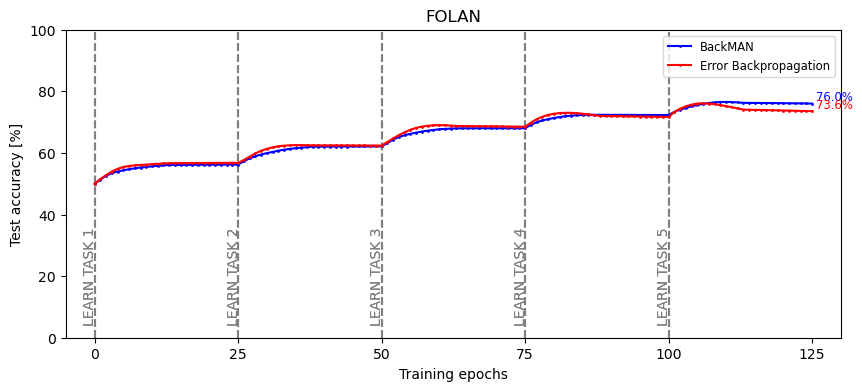

In [13]:
import numpy as np
import matplotlib.pyplot as plt

cmap_name={"greedy": "winter", "normal":"autumn"}
name_translation={"greedy": "BackMAN", "normal": "Error Backpropagation"}
fig, ax = plt.subplots(1,1, sharey="row", figsize=(10, 4))
for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)

    for task_id in range(5):
        ax.axvline(x=25*task_id, color='gray', linestyle='--')
        # Add text labels
        ax.text(25*task_id-2, 5, f'LEARN TASK {task_id+1}', color='gray', rotation='vertical', fontsize=10)

    x = np.arange(126)
    y = np.array(smean[mode])*100
    std_dev = np.array(sstd[mode])*100

    ax.text(132, y[-1], f'{y[-1]:.1f}%', ha='right', va='bottom', color=cmap(0), fontsize="small")
    # Plotting the error lines
    ax.errorbar(x, y, yerr=std_dev/2, linestyle='', color=cmap(0), elinewidth=0.5)

    # Customizing the plot
    ax.set_xlabel('Training epochs')
    ax.set_ylabel('Test accuracy [%]')
    ax.set_title("FOLAN")
    custom_ticks = [25*i for i in range(6)]
    ax.set_xticks(custom_ticks)
    ax.set_ylim(bottom=0, top=100)
    ax.set_xlim(-5,130)

for ax_id, mode in enumerate(smean.keys()):
    cmap=plt.cm.get_cmap(cmap_name[mode], 5)
    x = np.arange(126)
    y = np.array(smean[mode])*100
    ax.plot(x, y, marker='o', linestyle='-', color=cmap(0), label=name_translation[mode], markersize=1)
    ax.legend(fontsize='small')
plt.savefig('forgetting_v2_high.png', dpi=1000)
plt.show()

greedy winter (0.0, 0.0, 1.0, 1.0)
normal autumn (1.0, 0.0, 0.0, 1.0)


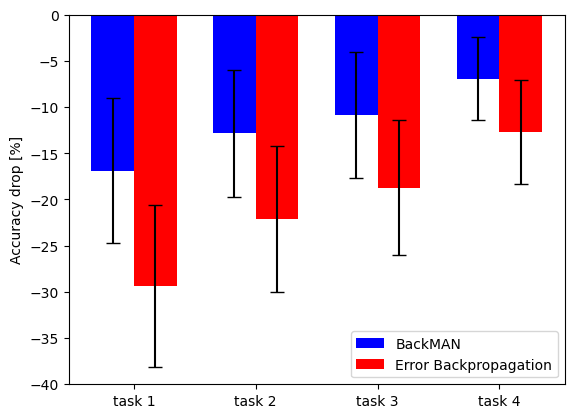

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example data


labels = [f'task {task_id+1}' for task_id in range(4)]
means = {mode: np.array([np.mean([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                         +accuracies[mode][f"task_{task_id}"][125][j]
                         for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}
std_devs = {mode: np.array([np.std([-accuracies[mode][f"task_{task_id}"][25*(task_id+1)][j]
                           +accuracies[mode][f"task_{task_id}"][125][j]
                           for j in range(100)]) for task_id in range(4)]) for mode
         in ['greedy', 'normal']}

# Create a bar plot with paired bars
fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.35

for sign, mode in zip([-1,+1],['greedy', 'normal']):
    cmap=plt.cm.get_cmap(cmap_name[mode], 2)
    print(mode, cmap_name[mode], cmap(0))
    ax.bar(x + sign*width/2, means[mode]*100, width, align='center', yerr=np.array(std_devs[mode]*100)/2, capsize=5, label=name_translation[mode], color=[cmap(0) for i in range(4)])

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Accuracy drop [%]')
# ax.set_title('Accuracy drop compared to')
ax.legend()

# Display the plot
plt.savefig('forgetting_v3_high.png', dpi=1000)
plt.show()


In [45]:
import wandb


api = wandb.Api()
runs = api.runs("ckodserteam/greedyNeuron6")
depth_runs = {"greedy": {i:[] for i in range(15)}, "normal": {i:[] for i in range(15)}}
for run in runs:
    if run.name.startswith("final_depth_exJUSTFORTEST") and run.config['seed'] != 0 and run.state=="finished":
        depth_runs[run.config['mode']][run.config['model_layers'].count("2000")].append(next(iter(run.history(keys=['performance_eval/best_test_accuracy']).iterrows()))[1]["performance_eval/best_test_accuracy"])

In [46]:
for k in depth_runs:
    for i in range(1,14):
        if len(depth_runs[k][i])==10:
            depth_runs[k][i]=list(set(depth_runs[k][i]))
        print(k,i,len(depth_runs[k][i]), depth_runs[k][i])

greedy 1 5 [0.9896, 0.9904, 0.9886, 0.9904, 0.9903]
greedy 2 5 [0.9915, 0.9911, 0.9922, 0.9918, 0.9916]
greedy 3 5 [0.9904, 0.9902, 0.9901, 0.9901, 0.9894]
greedy 4 5 [0.99, 0.9899, 0.9899, 0.9898, 0.9892]
greedy 5 5 [0.9907, 0.9911, 0.9898, 0.9893, 0.99]
greedy 6 5 [0.9904, 0.9903, 0.989, 0.99, 0.9894]
greedy 7 5 [0.9846, 0.9854, 0.9862, 0.9872, 0.9843]
greedy 8 5 [0.9841, 0.9852, 0.9841, 0.9856, 0.9842]
greedy 9 5 [0.9842, 0.9858, 0.9853, 0.9862, 0.9843]
greedy 10 5 [0.9844, 0.9849, 0.9859, 0.9864, 0.9847]
greedy 11 5 [0.9828, 0.9854, 0.9872, 0.9854, 0.982]
greedy 12 5 [0.9815, 0.9826, 0.9837, 0.9828, 0.9842]
greedy 13 0 []
normal 1 5 [0.9867, 0.987, 0.9856, 0.9853, 0.9854]
normal 2 5 [0.9876, 0.9855, 0.9867, 0.9877, 0.9866]
normal 3 5 [0.9885, 0.9884, 0.9879, 0.9876, 0.9873]
normal 4 5 [0.9875, 0.9879, 0.9867, 0.9862, 0.9847]
normal 5 5 [0.9799, 0.989, 0.9872, 0.9858, 0.9848]
normal 6 5 [0.9859, 0.9856, 0.9848, 0.9868, 0.987]
normal 7 5 [0.9846, 0.9856, 0.9813, 0.9685, 0.9839]
norma

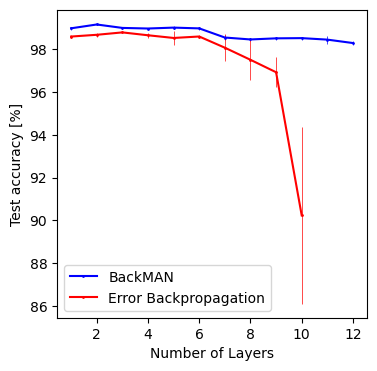

In [52]:
import numpy as np
import matplotlib.pyplot as plt

cmap_name={"greedy": "winter", "normal":"autumn"}
name_translation={"greedy": "BackMAN", "normal": "Error Backpropagation"}
fig, ax = plt.subplots(1,1, sharey="row", figsize=(4, 4))
for mode in cmap_name.keys():
    cmap=plt.cm.get_cmap(cmap_name[mode], 2)

    x = np.arange(1, 13)
    y = np.array([np.mean(depth_runs[mode][i]) if len(depth_runs[mode][i])>0 else 0.94  for i in range(1,13)])*100
    std_dev = np.array([np.std(depth_runs[mode][i]) if len(depth_runs[mode][i])>0 else 0  for i in range(1,13)])*100

    # Plotting the error lines
    ax.errorbar(x, y, yerr=std_dev, linestyle='', color=cmap(0), elinewidth=0.5)

    # Customizing the plot
    ax.set_xlabel('Number of Layers')
    ax.set_ylabel('Test accuracy [%]')
    # ax.set_ylim(bottom=0, top=100)
    # ax.set_xlim(-10,150)

for mode in cmap_name.keys():
    cmap=plt.cm.get_cmap(cmap_name[mode], 2)
    x = np.arange(1, 13)
    y = np.array([np.mean(depth_runs[mode][i])*100 if len(depth_runs[mode][i])>1 else None for i in range(1,13)])
    ax.plot(x, y, marker='o', linestyle='-', color=cmap(0), label=name_translation[mode], markersize=1)
ax.legend()
plt.savefig('depth_v1_high._square.png', dpi=1000)
plt.show()